In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import cholesky, sqrtm
from scipy.stats import norm, rv_histogram

In [2]:
bins = np.linspace(-2.5, 2.5, 50)

In [3]:
# Truth distribution
truth_1 = norm(loc=0, scale=1).rvs(100000)
truth_2 = norm(loc=-1, scale=0.2).rvs(100000)
truth_h = np.histogram(np.concatenate((truth_1, truth_2)), bins=bins)

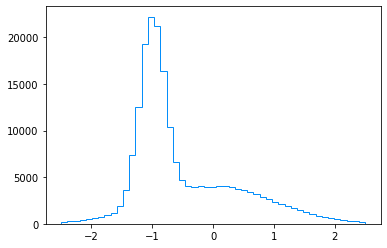

In [4]:
plt.stairs(*truth_h)

In [5]:
# Response matrix
N = len(bins) - 1
R = (
    np.diag([0.4] * N, k=0)
    + np.diag([0.15] * (N - 1), k=1)
    + np.diag([0.15] * (N - 1), k=-1)
    + np.diag([0.10] * (N - 2), k=2)
    + np.diag([0.10] * (N - 2), k=-2)
    + np.diag([0.05] * (N - 3), k=3)
    + np.diag([0.05] * (N - 3), k=-3)
)

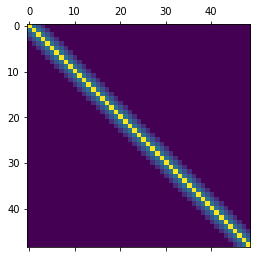

In [6]:
plt.matshow(R)

In [7]:
# Reco expectation
reco_h = (R @ truth_h[0], bins)

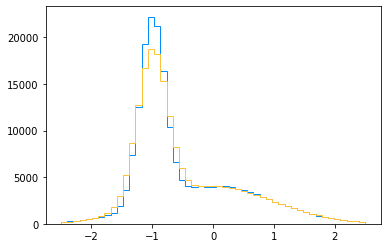

In [8]:
plt.stairs(*truth_h)
plt.stairs(*reco_h)

In [9]:
# Actual random data
reco_dist = rv_histogram(reco_h)()
data = reco_dist.rvs(1000)
data_h = np.histogram(data, bins=bins)

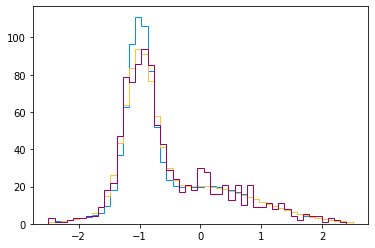

In [10]:
plt.stairs(truth_h[0] / 200, bins)
plt.stairs(reco_h[0] / 200, bins)
plt.stairs(*data_h)

In [11]:
# Matrix inversion unfolding
R_inv = np.linalg.inv(R)
unfolded_h = (R_inv @ data_h[0], bins)

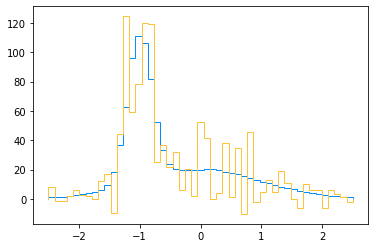

In [12]:
plt.stairs(truth_h[0] / 200, bins)
plt.stairs(*unfolded_h)

In [13]:
# Error bars
cov_data = np.diag(data_h[0] + 1)
cov_unfolded = R_inv @ cov_data @ R_inv.T
cor_unfolded = cov_unfolded / (
    np.sqrt(np.diag(cov_unfolded))[:, None] * np.sqrt(np.diag(cov_unfolded))[None, :]
)
cov_unfolded_inv = np.linalg.inv(cov_unfolded)
cor_unfolded[~np.isfinite(cor_unfolded)] = 0
np.max(cor_unfolded), np.min(cor_unfolded), np.min(cov_unfolded)

(1.0000000000000002, -0.5364875069861789, -457.0208928060756)

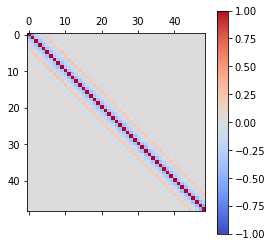

In [14]:
plt.matshow(cor_unfolded, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

In [15]:
# Regularisation
#
# \Delta \chi^2 = x^T C x
#
# C_1
C = np.diag([1] + [2] * (N - 2) + [1], k=0) + np.diag([-2] * (N - 1), k=1)
# Make symmetric
C = (C + C.T) / 2

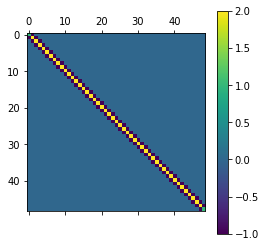

In [16]:
plt.matshow(C)
plt.colorbar()

In [17]:
# Regularised result
#
# m' = A m
# A = (cov^{-1} + C)^-1 cov^{-1}

# Scale so taus are in more convenient value range
C /= 1000
tau_list = [0.0] + list(np.logspace(-1, 1, 9))
A_list = [
    np.linalg.inv(cov_unfolded_inv + tau * C) @ cov_unfolded_inv for tau in tau_list
]
regularised_list = [A @ unfolded_h[0] for A in A_list]

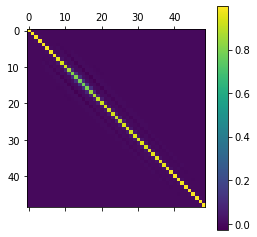

In [18]:
plt.matshow(A_list[1])
plt.colorbar()

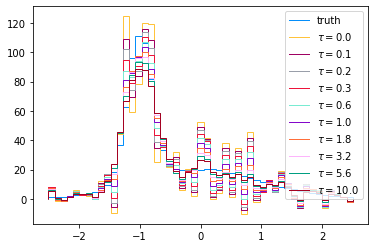

In [19]:
plt.stairs(truth_h[0] / 200, bins, label="truth")
for x, tau in zip(regularised_list, tau_list):
    plt.stairs(x, bins, label=fr"$\tau = {tau:3.1f}$")
plt.legend()

In [20]:
# Metrics
jaggedness = [x.T @ C @ x for x in regularised_list]
bias = [
    (x - unfolded_h[0]).T @ cov_unfolded_inv @ (x - unfolded_h[0])
    for x in regularised_list
]

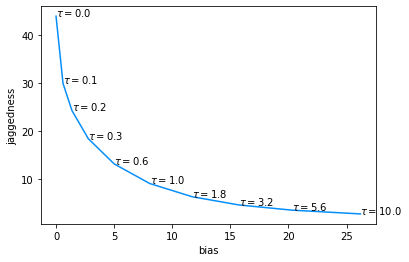

In [21]:
plt.plot(bias, jaggedness)
plt.xlabel("bias")
plt.ylabel("jaggedness")
for x, y, tau in zip(bias, jaggedness, tau_list):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))

In [22]:
# Alt metrics
# Determinant of covariance/correlation matrix as measure of overall correlation?
cov_list = [A @ cov_unfolded @ A.T for A in A_list]
cor_list = [
    np.diag(np.diag(cov) ** (-0.5)) @ cov @ np.diag(np.diag(cov) ** (-0.5))
    for cov in cov_list
]
cov_det_list = [np.linalg.det(cov) for cov in cov_list]
cor_det_list = [np.linalg.det(cor) for cor in cor_list]

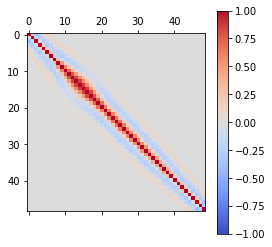

In [23]:
plt.matshow(cor_list[-1], cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

In [24]:
# Alt metrics
# Wasserstein distance in uncorrelated standard normal space
# The Fréchet distance between multivariate normal distributions
# https://doi.org/10.1016/0047-259X(82)90077-X
dist = []
diag_dist = []
U = cholesky(cov_unfolded_inv)
m = U @ unfolded_h[0]


def wasserstein(x, cov):
    diff = m - U @ x
    S = U @ cov @ U.T
    d = diff.T @ diff + cov.shape[0] + np.trace(S - 2 * sqrtm(S))
    return abs(d)  # Catch some numerical issues


for x, cov in zip(regularised_list, cov_list):
    # Distance between original and regularised
    dist.append(wasserstein(x, cov))
    # Distance between original and plot
    diag_dist.append(wasserstein(x, np.diag(np.diag(cov))))

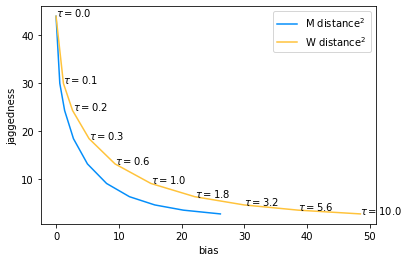

In [25]:
plt.plot(bias, jaggedness, label="M distance$^2$")
plt.plot(dist, jaggedness, label="W distance$^2$")
plt.legend()
plt.xlabel("bias")
plt.ylabel("jaggedness")
for x, y, tau in zip(dist, jaggedness, tau_list):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))

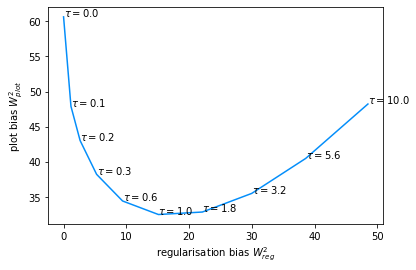

In [26]:
plt.plot(dist, diag_dist)
plt.xlabel("regularisation bias $W^2_{reg}$")
plt.ylabel("plot bias $W^2_{plot}$")
i_W = 0
best = np.inf
for i, (x, y, tau) in enumerate(zip(dist, diag_dist, tau_list)):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))
    if y < best:
        best = y
        i_W = i

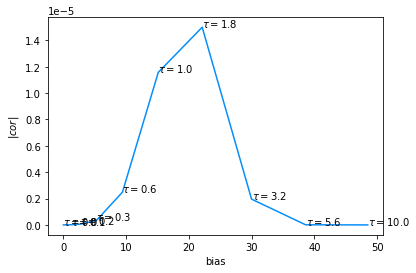

In [27]:
plt.plot(dist, cor_det_list)
plt.xlabel("bias")
plt.ylabel(r"$|cor|$")
i_D = 0
best = 0
for i, (x, y, tau) in enumerate(zip(dist, cor_det_list, tau_list)):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))
    if y > best:
        best = y
        i_D = i

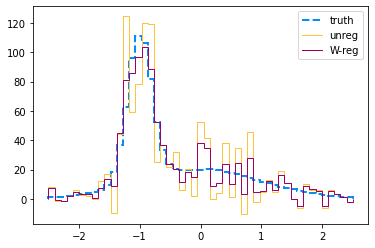

In [28]:
plt.stairs(truth_h[0]/200, bins, label="truth", linewidth=2, linestyle="dashed")
plt.stairs(*unfolded_h, label="unreg", linewidth=1)
plt.stairs(regularised_list[i_W], bins, label="W-reg")
plt.legend()

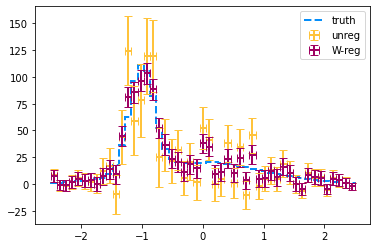

In [29]:
plt.stairs(truth_h[0]/200, bins, label="truth", linewidth=2, linestyle="dashed")

x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y = unfolded_h[0]
yerr = np.sqrt(np.diag(cov_unfolded))
plt.errorbar(
    x, y, yerr=yerr, xerr=xerr, label="unreg", linewidth=2, linestyle="", capsize=4
)

y = regularised_list[i_W]
yerr = np.sqrt(np.diag(cov_list[i_W]))
plt.errorbar(
    x, y, yerr=yerr, xerr=xerr, label="W-reg", linewidth=2, linestyle="", capsize=4
)

plt.legend()